In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
from scipy import stats

In [2]:
adata = sc.read('annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 58015 × 14469
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'low_major', 'Cell_Type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'low_major_colors', 'neighbors', 'overcluster', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

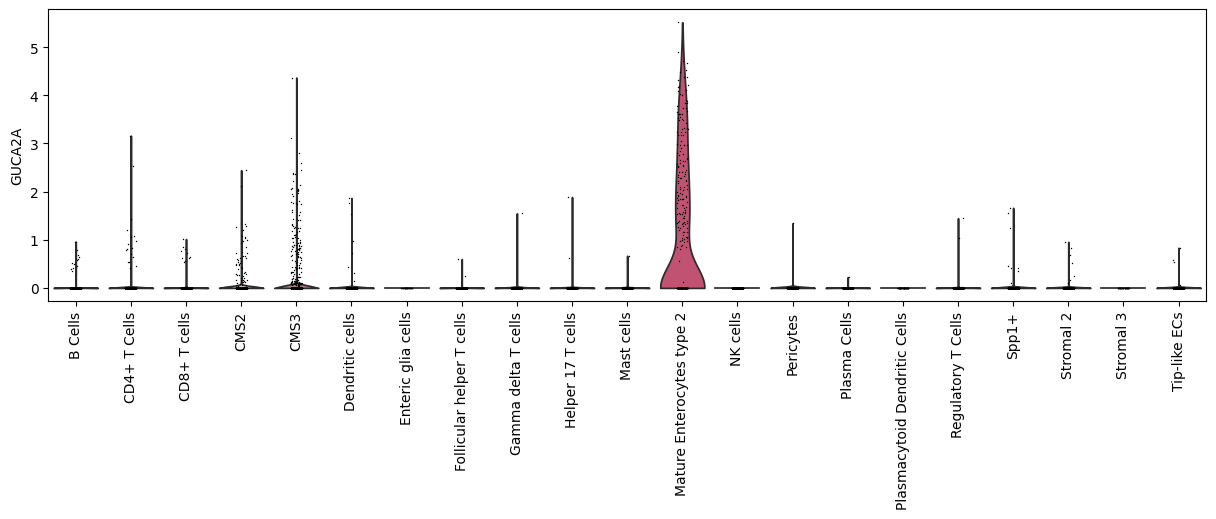

In [3]:
#fibroblats
with plt.rc_context({"figure.figsize": (12, 4)}):
    sc.pl.violin(adata, ["GUCA2A"], groupby="Cell_Type", rotation=90, )

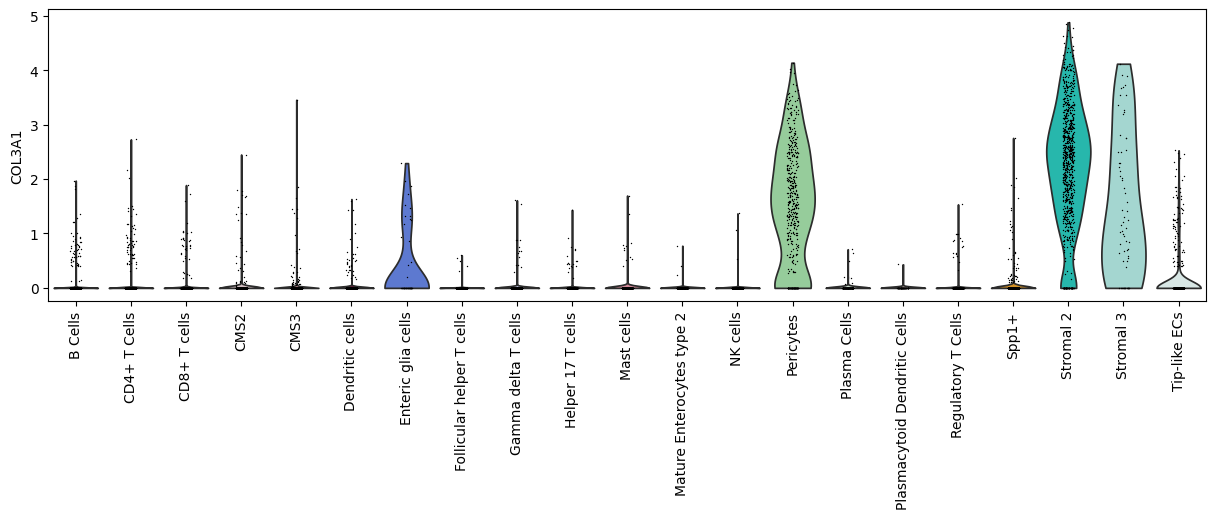

In [4]:
#fibroblats
with plt.rc_context({"figure.figsize": (12, 4)}):
    sc.pl.violin(adata, ["COL3A1"], groupby="Cell_Type", rotation=90, )

In [5]:
subset=adata[(adata.obs['Cell_Type'].isin(['Stromal 2']))].copy()
subset

AnnData object with n_obs × n_vars = 897 × 14469
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'low_major', 'Cell_Type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'low_major_colors', 'neighbors', 'overcluster', 'rank_genes_groups', 'umap', 'Cell_Type_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

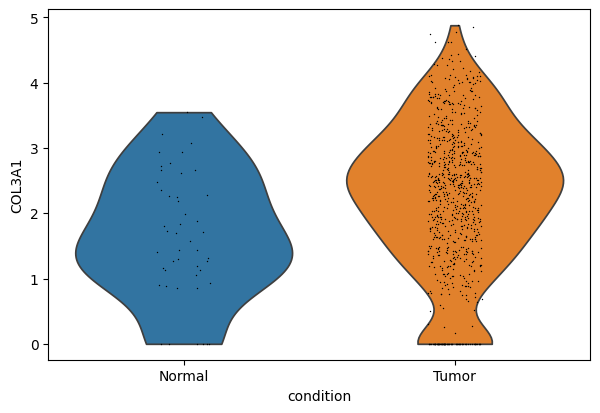

In [6]:
sc.pl.violin(subset,'COL3A1',groupby='condition')

In [7]:
i= np.where(subset.var_names=='COL3A1')[0][0]
i

2194

In [9]:
a = subset[subset.obs.condition == 'Tumor'].X[:,i]
b = subset[subset.obs.condition == 'Normal'].X[:,i]

In [11]:
if hasattr(a, 'toarray'):
    a = a.toarray().flatten()
if hasattr(b, 'toarray'):
    b = b.toarray().flatten()

In [12]:
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=26900.0, pvalue=0.00018625758660798064)

In [13]:


statistic, pvalue = stats.mannwhitneyu(a, b)
n1, n2 = len(a), len(b)

# Rank-biserial correlation (effect size)
r = 1 - (2*statistic) / (n1 * n2)  # ranges from -1 to 1

print(f"Effect size (rank-biserial r): {r:.3f}")

Effect size (rank-biserial r): -0.320


In [14]:
import numpy as np

# Add pseudocount to avoid log(0)
log2fc = np.log2((a.mean() + 1e-10) / (b.mean() + 1e-10))
print(f"Log2 Fold Change: {log2fc:.3f}")

Log2 Fold Change: 0.431


=== COL3A1 in Stromal 2 cells ===
Sample sizes: Tumor n=849, Normal n=48
Mann-Whitney U statistic: 26900.0
P-value: 1.86e-04
Effect size (r): -0.320
Log2 FC: 0.431

% expressing: Tumor 91.2%, Normal 87.5%
Mean expression (all cells): Tumor 2.252, Normal 1.671
Mean expression (expressing cells): Tumor 2.470, Normal 1.910


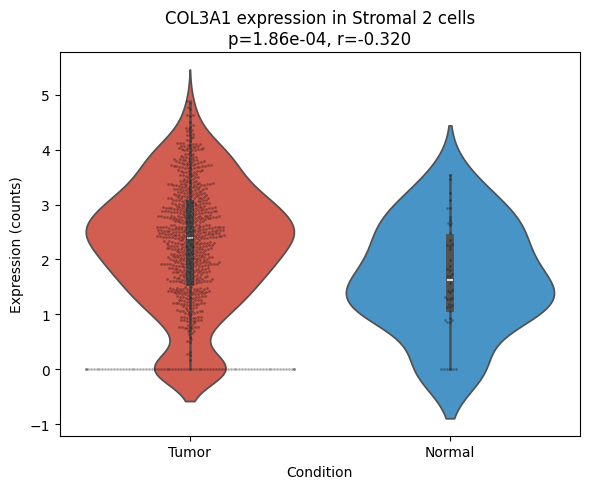

In [15]:

from scipy.sparse import issparse

# Subset to Stromal 2 cells
subset = adata[adata.obs['Cell_Type'].isin(['Stromal 2'])].copy()

# Get gene index
gene_name = 'COL3A1'
i = np.where(subset.var_names == gene_name)[0][0]

# Extract expression values (handle sparse matrix)
if issparse(subset.X):
    a = subset[subset.obs.condition == 'Tumor'].X[:, i].toarray().flatten()
    b = subset[subset.obs.condition == 'Normal'].X[:, i].toarray().flatten()
else:
    a = subset[subset.obs.condition == 'Tumor'].X[:, i].flatten()
    b = subset[subset.obs.condition == 'Normal'].X[:, i].flatten()

# Sample sizes
n_tumor = len(a)
n_normal = len(b)

# Statistical test
statistic, pvalue = stats.mannwhitneyu(a, b, alternative='two-sided')

# Effect size (rank-biserial correlation)
r = 1 - (2 * statistic) / (n_tumor * n_normal)

# Expression metrics
pct_tumor = (a > 0).sum() / n_tumor * 100
pct_normal = (b > 0).sum() / n_normal * 100
mean_tumor_all = a.mean()
mean_normal_all = b.mean()
mean_tumor_expr = a[a > 0].mean() if (a > 0).any() else 0
mean_normal_expr = b[b > 0].mean() if (b > 0).any() else 0

# Log2 fold change
log2fc = np.log2((mean_tumor_all + 1e-10) / (mean_normal_all + 1e-10))

# Report
print(f"=== {gene_name} in Stromal 2 cells ===")
print(f"Sample sizes: Tumor n={n_tumor}, Normal n={n_normal}")
print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {pvalue:.2e}")
print(f"Effect size (r): {r:.3f}")
print(f"Log2 FC: {log2fc:.3f}")
print(f"\n% expressing: Tumor {pct_tumor:.1f}%, Normal {pct_normal:.1f}%")
print(f"Mean expression (all cells): Tumor {mean_tumor_all:.3f}, Normal {mean_normal_all:.3f}")
print(f"Mean expression (expressing cells): Tumor {mean_tumor_expr:.3f}, Normal {mean_normal_expr:.3f}")

# Visualization
df_plot = pd.DataFrame({
    'Expression': np.concatenate([a, b]),
    'Condition': ['Tumor']*n_tumor + ['Normal']*n_normal
})

plt.figure(figsize=(6, 5))
sns.violinplot(data=df_plot, x='Condition', y='Expression', palette=['#e74c3c', '#3498db'])
sns.swarmplot(data=df_plot, x='Condition', y='Expression', color='black', alpha=0.3, size=2)
plt.title(f'{gene_name} expression in Stromal 2 cells\np={pvalue:.2e}, r={r:.3f}')
plt.ylabel('Expression (counts)')
plt.tight_layout()
plt.show()